#Neural Network classification with pytorch

In [1]:
from sklearn.datasets import make_circles
# make 1000  samples
n_samples = 1000

# create circles
x , y =  make_circles(n_samples , noise=0.03 , random_state=42)

In [2]:
len(x) , len(y)

(1000, 1000)

In [3]:

print(f"fist 5 smaple of x  : \n {x[:5]}")
print(f"fist 5 smaple of y : \n  {y[:5]}")

fist 5 smaple of x  : 
 [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
fist 5 smaple of y : 
  [1 1 1 1 0]


In [4]:
# make dataFrame of circle data
import pandas as pd

circles = pd.DataFrame({"x1":x[: , 0] ,
                       "x2" : x[: , 1] ,
                        "y" : y})
circles.head()

,x1,x2,y
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


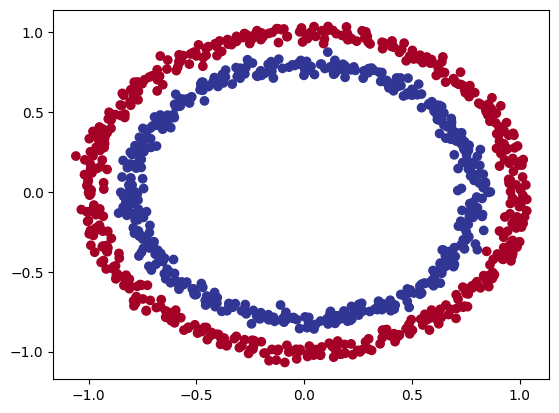

In [5]:
import matplotlib.pyplot as plt
plt.scatter(x=circles.x1 ,
            y=circles.x2 ,
            c=circles.y , cmap=plt.cm.RdYlBu )

In [6]:
x.shape , y.shape

((1000, 2), (1000,))

In [7]:
# Turn data into tensors
import torch
x = torch.from_numpy(x).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [8]:
type(x) , x.dtype

(torch.Tensor, torch.float32)

In [9]:
#Split data into training data and test
from sklearn.model_selection import train_test_split
trainX ,testX , trainY ,testY = train_test_split(x , y , test_size=0.2 , random_state=42)

In [10]:
len(trainX) ,  len(testX)

(800, 200)

In [11]:
import torch
from torch import nn

# make device
device ="cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [12]:
class CircleModelV0(nn.Module):
  def  __init__(self):
    super().__init__()

    self.layer1 =  nn.Linear(in_features= 2 , out_features=5)
    self.layer2 = nn.Linear(in_features=5 , out_features=1)

  def forward(self  , x ):
    return self.layer2(self.layer1(x)) # x -> layer1 -> layer2

model = CircleModelV0().to(device)
model


CircleModelV0(
  (layer1): Linear(in_features=2, out_features=5, bias=True)
  (layer2): Linear(in_features=5, out_features=1, bias=True)
)

In [13]:
#  replicate model above using nn.Sequential
model  = nn.Sequential(
      nn.Linear(in_features= 2 , out_features=5) ,
      nn.Linear(in_features=5 , out_features=1)
).to(device)
model

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [14]:
# combine these two

class CircleModelV0(nn.Module):
  def  __init__(self):
    super().__init__()

    self.twoLayer = nn.Sequential(
      nn.Linear(in_features= 2 , out_features=5) ,
      nn.Linear(in_features=5 , out_features=1)
    )

  def forward(self  , x ):
    return self.twoLayer(x)

model = CircleModelV0().to(device)
model

CircleModelV0(
  (twoLayer): Sequential(
    (0): Linear(in_features=2, out_features=5, bias=True)
    (1): Linear(in_features=5, out_features=1, bias=True)
  )
)

In [15]:
model.state_dict()

OrderedDict([('twoLayer.0.weight',
              tensor([[ 0.0202,  0.2135],
                      [ 0.4310,  0.5408],
                      [-0.4701, -0.5253],
                      [-0.3081,  0.0291],
                      [-0.5880,  0.3933]], device='cuda:0')),
             ('twoLayer.0.bias',
              tensor([ 0.2415,  0.4902,  0.6144, -0.3240, -0.1280], device='cuda:0')),
             ('twoLayer.1.weight',
              tensor([[ 0.0435, -0.1215,  0.1976,  0.1897, -0.1041]], device='cuda:0')),
             ('twoLayer.1.bias', tensor([0.3200], device='cuda:0'))])

In [16]:
#setup loss function

loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(params=model.parameters(),
                            lr=0.1)



In [17]:
def accuracy_fn(y_true , y_pred):
  correct = torch.eq(y_true , y_pred).sum().item()
  acc = (correct/len(y_pred)) * 100
  return acc

#train model
1.forward pass

2.calculate the loss

3.optimizer zero

4.loss backward (backpropagation)

5.optimizer step (gradient descent)


In [18]:
#raw logits
model.eval()
with torch.inference_mode():
  y_logits = model(testX.to(device))[:5]
y_logits

tensor([[0.2638],
        [0.1542],
        [0.5053],
        [0.1955],
        [0.4327]], device='cuda:0')

In [19]:
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.5656],
        [0.5385],
        [0.6237],
        [0.5487],
        [0.6065]], device='cuda:0')

In [20]:
# Find the predicted labels (round the prediction probabilities)
y_preds = torch.round(y_pred_probs)

# In full
y_pred_labels = torch.round(torch.sigmoid(model(testX.to(device))[:5]))

# Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# Get rid of extra dimension
y_preds.squeeze()

tensor([True, True, True, True, True], device='cuda:0')


tensor([1., 1., 1., 1., 1.], device='cuda:0')

##building the training  and testing  loop

In [21]:
torch.manual_seed(42)

#epochs num
epochs = 100

#put data to  target device
trainX , trainY = trainX.to(device) , trainY.to(device)
testX , testY = testX.to(device) , testY.to(device)

#build trainingand evaluation loop
for epoch  in  range(epochs):
  #training
  model.train()

  # 1. forward pass
  y_logits= model(trainX).squeeze()
  y_pred  = torch.round(torch.sigmoid(y_logits)) # logits -> pred_probs ->  pred_labels

  # 2calculate the  loss
  loss = loss_fn(y_logits, trainY)
  acc  = accuracy_fn(y_true= trainY , y_pred=  y_pred)

  # 3.  opitimizer  zero grad
  optimizer.zero_grad()

  # 4.loss backward(backpropagation)
  loss.backward()

  #  5.optimizer  step (gradient descent)
  optimizer.step()

  ### testing
  model.eval()
  with torch.inference_mode():
    # 1.forward pass
    test_logits = model(testX).squeeze()
    test_pred =torch.round(torch.sigmoid(test_logits))
    # 2calculate the loss
    test_loss =  loss_fn(test_logits , testY)
    test_acc =  accuracy_fn(testY , test_pred)


  ## print out what's going on
  if epoch  % 10 == 0:
    print(f"Epoch:{epoch}| loss:{loss:.5f} , Acc:{acc:.2f}% | Test loss: {test_loss:.5f}, Test Acc{test_acc:.2f}%")



Epoch:0| loss:0.71241 , Acc:50.00% | Test loss: 0.70297, Test Acc50.00%
Epoch:10| loss:0.70231 , Acc:50.62% | Test loss: 0.69523, Test Acc53.00%
Epoch:20| loss:0.69807 , Acc:55.50% | Test loss: 0.69242, Test Acc54.00%
Epoch:30| loss:0.69615 , Acc:52.25% | Test loss: 0.69148, Test Acc54.00%
Epoch:40| loss:0.69518 , Acc:51.25% | Test loss: 0.69125, Test Acc52.50%
Epoch:50| loss:0.69462 , Acc:50.62% | Test loss: 0.69130, Test Acc53.00%
Epoch:60| loss:0.69425 , Acc:50.25% | Test loss: 0.69145, Test Acc53.00%
Epoch:70| loss:0.69399 , Acc:49.88% | Test loss: 0.69164, Test Acc53.00%
Epoch:80| loss:0.69379 , Acc:49.75% | Test loss: 0.69184, Test Acc53.50%
Epoch:90| loss:0.69363 , Acc:49.38% | Test loss: 0.69204, Test Acc53.50%


In [22]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

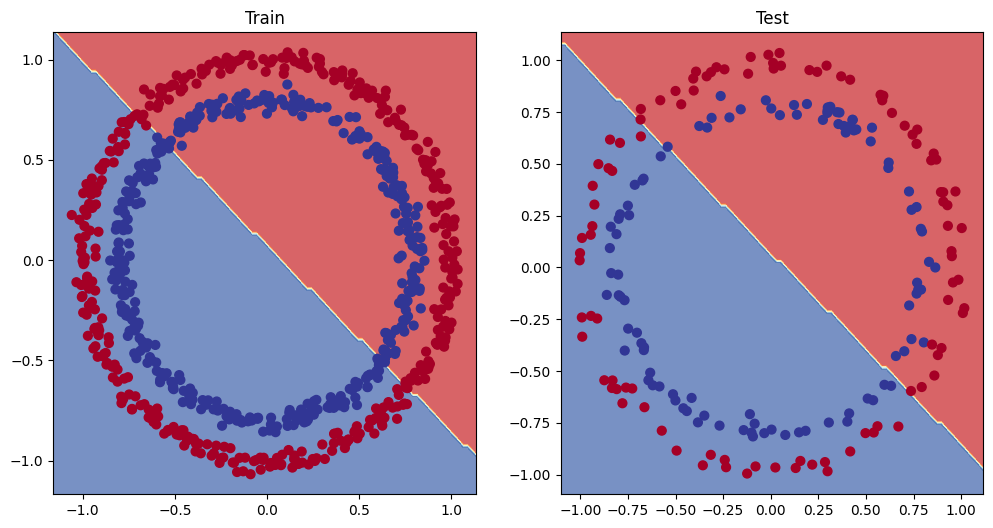

In [23]:
#plot decsion boubndary of the model
plt.figure(figsize=(12,6))
plt.subplot(1 ,2  ,1)
plt.title("Train")
plot_decision_boundary(model , trainX ,trainY)
plt.subplot(1 ,2  ,2)
plt.title("Test")
plot_decision_boundary(model , testX ,testY)


improving our model


In [24]:
class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2 ,   out_features=10)
    self.layer_2  = nn.Linear(in_features=10 ,   out_features=10)
    self.layer_3 = nn.Linear(in_features=10 ,   out_features=1)

  def forward(self,x):
    # z = self.layar_1(x)
    # z = self.layar_2(z)
    # z = self.layar_3(z)
    return self.layer_3(self.layer_2(self.layer_1(x)))

model = CircleModelV1().to(device)
model

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [25]:
class CircleModelV2(nn.Module):
  def __init__(self):
    super().__init__()

    self.layer1 = nn.Linear(in_features=2 , out_features=10)
    self.layer2 = nn.Linear(in_features=10 , out_features=10)
    self.layer3 = nn.Linear(in_features=10 , out_features=1)
    self.relu = nn.ReLU() #non  linear a activation  function

  def forward(self,x):
    return self.layer3(self.relu(self.layer2(self.relu(self.layer1(x)))))


model = CircleModelV2().to(device)

In [26]:
model

CircleModelV2(
  (layer1): Linear(in_features=2, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=10, bias=True)
  (layer3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

#multi-class classification

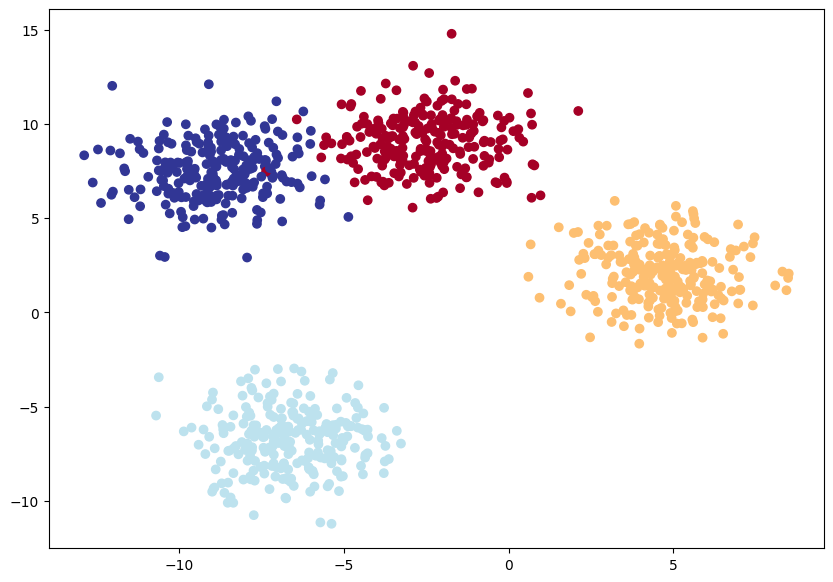

In [27]:
from  sklearn.datasets import  make_blobs


num_classes = 4


Xblob, Yblob= make_blobs(n_samples=1000 , n_features=2
                        ,centers= num_classes
                        ,cluster_std= 1.5
                        ,random_state=42)
Xblob =torch.from_numpy(Xblob).type(torch.float)
Yblob =torch.from_numpy(Yblob).type(torch.LongTensor)


trainX , testX , trainY , testY = train_test_split(Xblob , Yblob  , test_size=0.2 , random_state=42)

plt.figure(figsize=(10 ,7))
plt.scatter(Xblob[:,0],Xblob[:,1],c=Yblob , cmap=plt.cm.RdYlBu)

In [28]:
class BlobModel(nn.Module):
  def __init__(self , input_features ,output_features , hidden_units=8):
    super().__init__()
    self.linear_layer_stack =  nn.Sequential(
        nn.Linear(in_features= input_features,  out_features= hidden_units ),
        nn.ReLU(),
        nn.Linear(in_features= hidden_units,  out_features= hidden_units),
        nn.ReLU(),
        nn.Linear(in_features= hidden_units,  out_features=output_features)
    )

  def forward(self,x):
    return self.linear_layer_stack(x)

model = BlobModel(input_features=2  , output_features=4).to(device)
model

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [29]:
#loss  , optimize

loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(params=model.parameters(),lr=0.1)

In [30]:
model.eval()
with torch.inference_mode():
  y_logits= model(testX.to(device))
y_logits[:5]

tensor([[-0.0462, -0.1036, -0.4771,  0.3708],
        [ 0.2658,  0.3746, -0.5768,  0.4585],
        [ 0.0682, -0.0589, -0.3400,  0.2717],
        [ 0.0081, -0.0296, -0.3742,  0.2887],
        [ 0.2969, -0.0847, -0.4353,  0.1713]], device='cuda:0')

In [31]:
#training loop
torch.manual_seed(42)

epochs = 100

#put data to  target device
trainX , trainY = trainX.to(device) , trainY.to(device)
testX , testY = testX.to(device) , testY.to(device)


for epoch in range(epochs):
  #train
  model.train()
  #forward pass
  y_logits= model(trainX)
  y_pred = torch.softmax(y_logits ,dim=1).argmax(dim=1)
  #cal loss
  loss= loss_fn(y_logits, trainY)
  acc=accuracy_fn(trainY,  y_pred)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model.eval()
  with torch.inference_mode():
    test_logits =model(testX)
    test_preds =torch.softmax(test_logits , dim=1).argmax(dim=1)

    test_loss = loss_fn(test_logits ,testY)
    test_acc = accuracy_fn(y_true=testY , y_pred=test_preds)

  if epoch  % 10 == 0:
    print(f"Epoch:{epoch}| loss:{loss:.5f} , Acc:{acc:.2f}% | Test loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")




Epoch:0| loss:1.35157 , Acc:40.50% | Test loss: 1.20972, Test Acc: 61.00%
Epoch:10| loss:0.62558 , Acc:72.25% | Test loss: 0.61148, Test Acc: 72.00%
Epoch:20| loss:0.28055 , Acc:99.00% | Test loss: 0.25700, Test Acc: 100.00%
Epoch:30| loss:0.11051 , Acc:99.12% | Test loss: 0.09935, Test Acc: 99.50%
Epoch:40| loss:0.06929 , Acc:99.12% | Test loss: 0.06037, Test Acc: 99.50%
Epoch:50| loss:0.05362 , Acc:99.25% | Test loss: 0.04493, Test Acc: 99.50%
Epoch:60| loss:0.04561 , Acc:99.25% | Test loss: 0.03683, Test Acc: 99.50%
Epoch:70| loss:0.04080 , Acc:99.25% | Test loss: 0.03187, Test Acc: 99.50%
Epoch:80| loss:0.03761 , Acc:99.25% | Test loss: 0.02854, Test Acc: 99.50%
Epoch:90| loss:0.03535 , Acc:99.25% | Test loss: 0.02615, Test Acc: 99.50%


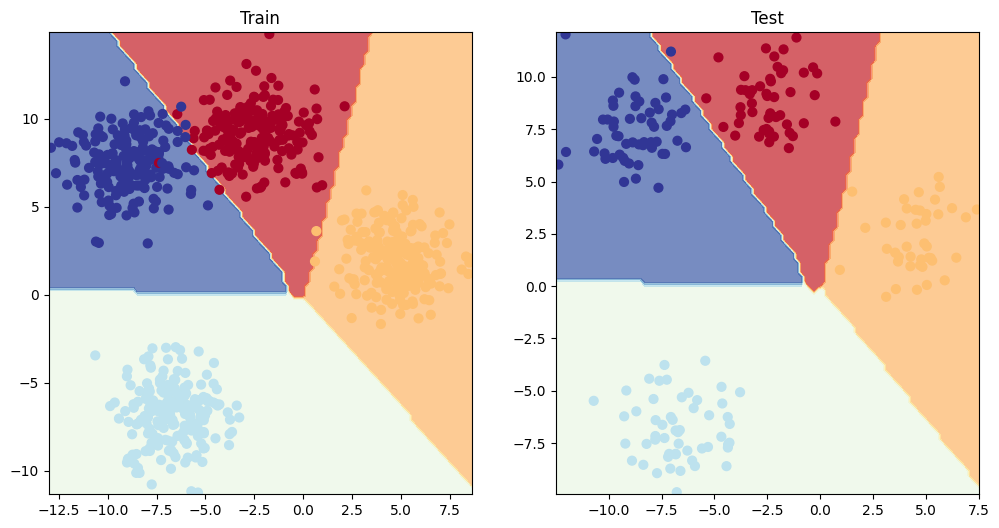

In [32]:
#plot decsion boubndary of the model
plt.figure(figsize=(12,6))
plt.subplot(1 ,2  ,1)
plt.title("Train")
plot_decision_boundary(model , trainX ,trainY)
plt.subplot(1 ,2  ,2)
plt.title("Test")
plot_decision_boundary(model , testX ,testY)